In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import fu, nu
from datetime import date, timedelta
from pandas import DataFrame, to_datetime, Series
import numpy as np
import os
import os.path as osp
from IPython.display import HTML
import pandas as pd

In [3]:

file_path = '../data/xlsx/anova290_df_Apr24_Final.xlsx'
anova_apr24_final_df = pd.read_excel(file_path)


We are requesting some additional data and I'm hoping this is possible. When convenient, could you add to the anova_df data set one column for each measure below and indicate for each responder as follows:<ul>
    <li>swap measure: put the number of patient swaps (0,1,2,3,4,5)</li>
    <li>walker issue command: whether the responder issued the walk command (1) or not (0)</li>
    <li>waver issue command: whether the responder issued the wave command (1) or not (0)</li>
</ul>
So it should like this:<table>
<tr><th>ID</th><th>swap measure</th><th>walker command</th><th>wave command</th></tr>
<tr><td>Responder 1</td><td>0</td><td>1</td><td>1</td></tr>
<tr><td>Responder 2</td><td>2</td><td>1</td><td>1</td></tr>
<tr><td>Responder 3</td><td>1</td><td>0</td><td>1</td></tr></table>

In [7]:

if 'scene_id' in anova_apr24_final_df.columns:
    for (session_uuid, scene_id), scene_df in anova_apr24_final_df.groupby(fu.scene_groupby_columns):
        actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_patient_sort_sequences(scene_df)
        print(actual_sequence, ideal_sequence, sort_dict)
else: print('\\b(' + '|'.join(sorted(anova_apr24_final_df.columns)) + ')\\b')

\b(Group|ID|critical_triage_error_rate|encounter_layout|file_name|mean_percentage_tag_correct|over_triage_error_rate|session_file_name|session_uuid|time_to_hemorrhage_control_per_patient|time_to_last_hemorrhage_controlled|time_to_triage_scene|under_triage_error_rate)\b


In [6]:

from scipy.stats import kendalltau

rows_list = []
for (session_uuid, scene_id), scene_df in anova_apr24_final_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    
    actual_sequence, ideal_sequence, sort_dict = fu.get_actual_and_ideal_patient_sort_sequences(scene_df)
    if pd.isna(actual_sequence).all(): continue
    row_dict = nu.get_flattened_dictionary(actual_sequence.tolist(), row_dict=row_dict, key_prefix='actual_sequence')
    row_dict = nu.get_flattened_dictionary(ideal_sequence.tolist(), row_dict=row_dict, key_prefix='ideal_sequence')
    
    engagement_order = fu.get_actual_engagement_order(scene_df)
    engagement_order_dicts_list = [
        {
            'patient_id': engagement_tuple[0],
            'engagement_start': engagement_tuple[1],
            'location_tuple': engagement_tuple[2],
            'patient_sort': engagement_tuple[3],
            'predicted_priority': engagement_tuple[4],
            'injury_severity': engagement_tuple[5]
        } for engagement_tuple in engagement_order
    ]
    row_dict = nu.get_flattened_dictionary(engagement_order_dicts_list, row_dict=row_dict, key_prefix='engagement_order')
    
    actual_patient_sequence = Series([engagement_dict.get(engagement_tuple[0]) for engagement_tuple in engagement_order])
    row_dict = nu.get_flattened_dictionary(actual_patient_sequence.tolist(), row_dict=row_dict, key_prefix='actual_patient_sequence')
    
    ideal_patient_sequence = actual_patient_sequence.sort_values(ascending=True)
    row_dict = nu.get_flattened_dictionary(ideal_patient_sequence.tolist(), row_dict=row_dict, key_prefix='ideal_patient_sequence')
    
    measure_of_ordering = fu.get_measure_of_ordering(actual_patient_sequence, ideal_patient_sequence)
    row_dict['measure_of_ordering'] = measure_of_ordering

    swaps_to_perfect_order = nu.count_swaps_to_perfect_order(ideal_patient_sequence.tolist(), actual_patient_sequence.tolist())
    row_dict['swaps_to_perfect_order'] = swaps_to_perfect_order
    
    # Calculate Kendall's tau coefficient
    tau, p_value = kendalltau(ideal_patient_sequence.tolist(), actual_patient_sequence.tolist())
    row_dict['kendall_tau_coefficient'] = tau
    
    rows_list.append(row_dict)
measure_of_ordering_df = DataFrame(rows_list)

In [4]:

# anova_apr24_final_df.Group.unique().tolist()
groups_list = ['Paramedic', 'EMT-Basic', 'EM Resident', 'Medical Student']
mask_series = anova_apr24_final_df.Group.isin(groups_list)
anova_df = anova_apr24_final_df[mask_series]

In [7]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df='', count_swaps_df='',
    verbose=False
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 367627 290 111
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 290 290 19
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 420 290 48
count_swaps_df = data_frames_dict['count_swaps_df']
print('count_swaps_df', count_swaps_df.shape[0], count_swaps_df.session_uuid.nunique(), count_swaps_df.shape[1]) # 289 289 3

triage_paper_df 367627 290 111
file_stats_df 290 290 19
scene_stats_df 420 290 48
count_swaps_df 315 289 3


In [8]:

# Merge only count swaps scenes
patient_count_filter_fn = lambda scene_df: True
elevens_df = fu.get_elevens_data_frame(
    triage_paper_df,
    file_stats_df,
    scene_stats_df,
    needed_columns=[
        'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'overall_category', 'file_name', 'session_file_name',
        'encounter_layout'
    ],
    patient_count_filter_fn=None
)
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 365543 289 120

elevens_df 365543 289 120


In [9]:

mask_series = elevens_df.responder_category.isin(groups_list)
elevens_df = elevens_df[mask_series]

In [16]:

# Get whisker plot for various measures
import seaborn as sns
import matplotlib.pyplot as plt
from random import uniform  # for jitter

temporalize_fn = lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes')
FILTERED_CATEGORIES_LIST = ['Paramedic', 'EMT-Basic', 'EM Resident', 'Medical Student']
def get_plot_dataframe(
    y_column_name, scene_fn, logs_df=elevens_df, x_column_name='responder_category', responder_categories_list=FILTERED_CATEGORIES_LIST, verbose=False
):
    '''
    The order and labeling should be (from left to right):
        EMT-Paramedic
        EMT-Basic
        EM-Resident
        Medical Student
    '''
    rows_list = []
    for responder_category in responder_categories_list:
        if verbose: print('responder_category:', responder_category)
        mask_series = (logs_df[x_column_name] == responder_category)
        responder_categories_df = logs_df[mask_series]
        gb = responder_categories_df.groupby(fu.scene_groupby_columns)
        for (session_uuid, scene_id), scene_df in gb:
            row_dict = {}
            if 'session_uuid' in scene_df.columns: row_dict['session_uuid'] = session_uuid
            if 'scene_id' in scene_df.columns: row_dict['scene_id'] = scene_id
            row_dict[x_column_name] = responder_category
            row_dict[y_column_name] = scene_fn(scene_df)
            row_dict['scene_count'] = gb.size().shape[0]
            rows_list.append(row_dict)
    df = DataFrame(rows_list)
    
    return df

In [17]:

def show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, print_responder_counts=False, verbose=False):
    df = get_plot_dataframe(y_column_name, scene_fn, logs_df=logs_df, verbose=verbose)
    x_column_name = 'responder_category'
    x_label = ' '.join([w.title() for w in x_column_name.split('_')])

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    # Create a box plot under the scatter plot; put a black square for the mean instead
    ax = sns.boxplot(
        ax=ax,
        data=df,
        fliersize=0.0,
        meanprops={'marker': 's', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 8},
        showmeans=True,
        x=x_column_name,
        y=y_column_name,
    )

    # Jitter amount
    jitter_amt = 0.1  # Adjust this value to control jitter range

    # Add jittered points
    sns.stripplot(
        alpha=0.25,  # Adjust transparency
        ax=ax,
        color='black',
        data=df,
        jitter=jitter_amt,  # Add jitter
        s=6,  # Adjust marker size
        x=x_column_name,
        y=y_column_name,
    )
    
    adjust_plot(ax, x_label, y_label, FILTERED_CATEGORIES_LIST, ytick_fn)
    plt.show()

In [21]:

mask_series = ~elevens_df.responder_category.isnull()
CATEGORY_DICT = {responder_category: responder_category for responder_category in elevens_df[mask_series].responder_category}
def adjust_plot(ax, x_label, y_label, responder_categories_list, ytick_fn=temporalize_fn):
    
    # Rotate the x-axis labels to prevent overlapping
    plt.xticks(rotation=45)

    # Label the x- and y-axis
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Humanize y tick labels
    locs, labels = plt.yticks()
    yticklabels_list = []
    for ytick_value, text_obj in zip(locs, labels):
        text_obj.set_text(ytick_fn(ytick_value))
        yticklabels_list.append(text_obj)
    plt.yticks(locs[1:], yticklabels_list[1:])

    # Re-label x tick labels
    locs, labels = plt.xticks()
    xticklabels_list = []
    for idx, text_obj in zip(locs, labels):
        text_obj.set_text(CATEGORY_DICT[responder_categories_list[idx]])
        xticklabels_list.append(text_obj)
    plt.xticks(locs, xticklabels_list)

In [40]:

rows_list = []
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.scene_groupby_columns}
    row_dict['triage_time'] = fu.get_triage_time(scene_df, verbose=False)
    rows_list.append(row_dict)
triage_time_df = DataFrame(rows_list)
display(triage_time_df.sort_values('triage_time'))

,session_uuid,scene_id,triage_time
185,a7804ee3-6a1c-4462-957a-17976a540483,0,19615
171,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13,0,41340
36,1e7d274d-f393-4888-9f28-4de53b0260e3,0,78928
266,f0a4acff-b70a-4577-a27e-df492cb9638d,0,244401
25,1563e213-aaa4-4b79-84a1-8f917ea9f7a9,0,249628
...,...,...,...
232,d81f6dfd-3151-415f-a354-541240e7fbae,0,791540
39,20168f93-040c-4290-aa7e-2b197825c9de,0,800854
239,de04bec3-9503-467c-9c49-675720c4bab0,0,808968
51,27c2fa44-ba05-417c-ae95-317b06870dc9,0,824136


In [44]:

on_columns = list(set(triage_time_df.columns).intersection(set(elevens_df.columns)))
mask_series = (triage_time_df.triage_time > 200_000)
merge_df = elevens_df.merge(triage_time_df[mask_series], on=on_columns)

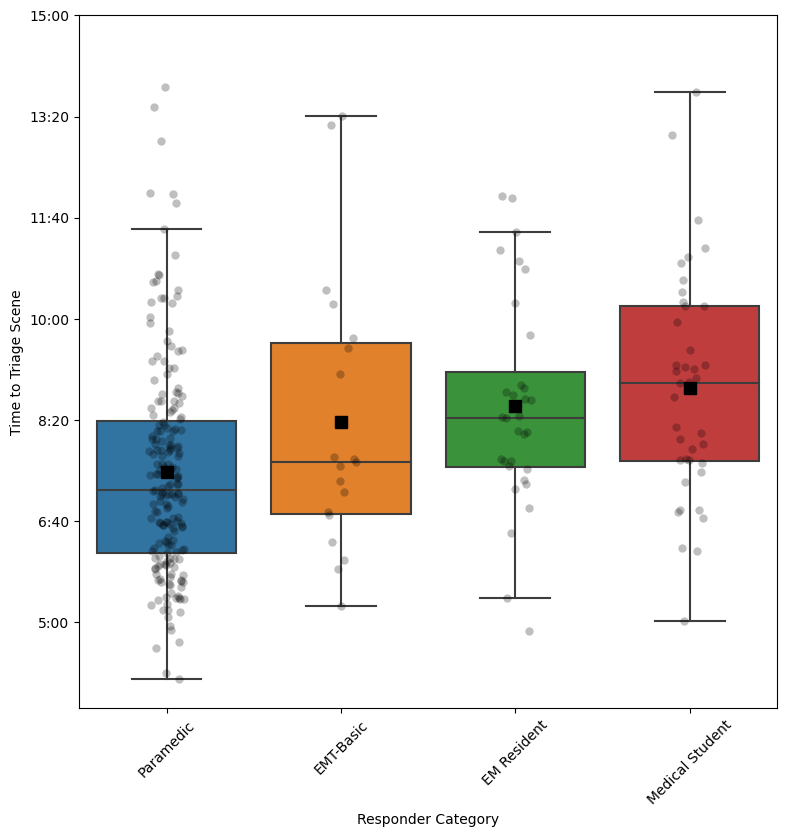

In [45]:

y_column_name = 'triage_time'
y_label = 'Time to Triage Scene'
scene_fn = lambda scene_df: fu.get_triage_time(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=merge_df, verbose=False)

In [48]:

mask_series = (triage_time_df.triage_time > 200_000)
on_columns = list(set(file_stats_df.columns).intersection(set(triage_time_df[~mask_series].columns)))
triage_time_df[~mask_series].merge(file_stats_df, on=on_columns).T

,0,1,2
session_uuid,1e7d274d-f393-4888-9f28-4de53b0260e3,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13,a7804ee3-6a1c-4462-957a-17976a540483
scene_id,0,0,0
triage_time,78928,41340,19615
file_name,First responder master registry v2.0/23.05.11....,First responder master registry v2.0/22.03.15....,First responder master registry v2.0/23.03.15....
logger_version,1.0,1.0,1.0
session_file_date,2023-05-11 11:37:00,2022-03-15 09:38:00,2023-03-15 12:20:34
session_file_name,23.05.11.1121.csv,22.03.15.0946.csv,23.03.15.1203r.csv
responder_name,Fred H,ZS_1000,Christian B
responder_type,Paramedic,M4-ATEM,EM-RES1
site_name,Plain Twp,OSUCOM,OSUCOM



# Create the dataset used to transform variables (to minutes) and run analyses

In [50]:

def get_mean_percentage_tag_correct(percentage_tag_correct_df, session_uuid, scene_id, responder_category):
    mean_percentage_tag_correct = 0
    mask_series = (percentage_tag_correct_df.session_uuid == session_uuid) & (percentage_tag_correct_df.scene_id == scene_id)
    mask_series &= (percentage_tag_correct_df.responder_category == responder_category)
    if mask_series.any(): mean_percentage_tag_correct = percentage_tag_correct_df[mask_series].percentage_tag_correct.mean()
    
    return mean_percentage_tag_correct

In [53]:

# Create the tag-to-SALT data frame
assert len(set(elevens_df.columns).intersection(set(fu.patient_groupby_columns))) == 3, "You don't have all the patient columns"
tag_to_salt_df = fu.get_is_tag_correct_data_frame(elevens_df, groupby_column='responder_category')

In [54]:

# Get the percentage tag correct counts for each scene for each group
percentage_tag_correct_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='responder_category')
remove_mask_series = (percentage_tag_correct_df.percentage_tag_correct == 0)
percentage_tag_correct_df = percentage_tag_correct_df[~remove_mask_series]

In [57]:

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan

    return error_type
groupby_columns = ['session_uuid', 'last_tag', 'max_salt', 'responder_category']
anova_error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
anova_error_types_df['error_type'] = anova_error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
anova_error_types_df['last_tag'] = anova_error_types_df['last_tag'].astype(fu.colors_category_order)
anova_error_types_df['max_salt'] = anova_error_types_df['max_salt'].astype(fu.salt_category_order)
anova_error_types_df['error_type'] = anova_error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
anova_error_types_df = anova_error_types_df.sort_values(by=groupby_columns+['error_type'])

In [58]:

# Get triage error rates
import re

rows_list = []
for (session_uuid, responder_category), responder_categories_df in anova_error_types_df.groupby(['session_uuid', 'responder_category']):
    row_dict = {'responder_category': responder_category, 'session_uuid': session_uuid}
    df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
    total_patient_count = df.patient_count.sum()
    error_dict = df.set_index('error_type').patient_count.to_dict()

    over_patient_count = error_dict.get('Over', 0)
    over_triage_error_rate = 100*over_patient_count/total_patient_count
    row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

    under_patient_count = error_dict.get('Under', 0)
    under_triage_error_rate = 100*under_patient_count/total_patient_count
    row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

    critical_patient_count = error_dict.get('Critical', 0)
    critical_triage_error_rate = 100*critical_patient_count/total_patient_count
    row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)
    
    rows_list.append(row_dict)
anova_error_rates_df = DataFrame(rows_list)

In [60]:

# Create the dataset used to transform variables (to minutes) and run analyses
mask_series = (elevens_df.scene_type == 'Triage') & (elevens_df.is_scene_aborted == False)
gb = elevens_df[mask_series].sort_values(['session_uuid']).groupby(['file_name', 'session_file_name', 'session_uuid', 'responder_category', 'encounter_layout'])
rows_list = []
for i, ((file_name, session_file_name, session_uuid, responder_category, encounter_layout), session_df) in enumerate(gb):

    # Get the tuple with the largest percentage correct
    largest_tuple = sorted(
        [(scene_df, scene_df.shape[0], scene_id) for scene_id, scene_df in session_df.groupby('scene_id')],
        key=lambda x: get_mean_percentage_tag_correct(percentage_tag_correct_df, session_uuid, x[2], responder_category)
    )[-1]
    
    responder_categories_df = largest_tuple[0]
    scene_id = largest_tuple[2]
    # scene_start = fu.get_scene_start(responder_categories_df)
    row_dict = {
        'ID': f'Responder {i+1}', 'Group': responder_category, 'file_name': file_name, 'session_file_name': session_file_name,
        'session_uuid': session_uuid, 'scene_id': scene_id, 'patient_count': fu.get_patient_count(responder_categories_df)
    }
    row_dict['time_to_triage_scene'] = fu.get_triage_time(responder_categories_df)
    row_dict['time_to_last_hemorrhage_controlled'] = fu.get_time_to_last_hemorrhage_controlled(responder_categories_df)
    
    # Duration of time from when the patient was first approached by the participant until
    # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
    row_dict['time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(responder_categories_df)
    
    mask_series = (percentage_tag_correct_df.session_uuid == session_uuid) & (percentage_tag_correct_df.scene_id == scene_id)
    mask_series &= (percentage_tag_correct_df.responder_category == responder_category)
    if mask_series.any():
        row_dict['mean_percentage_tag_correct'] = percentage_tag_correct_df[mask_series].percentage_tag_correct.mean()
        
        # Add the triage errors
        mask_series = (anova_error_rates_df.responder_category == responder_category) & (anova_error_rates_df.session_uuid == session_uuid)
        over_triage_error_rate = anova_error_rates_df[mask_series].over_triage_error_rate.squeeze()
        if not isinstance(over_triage_error_rate, Series): row_dict['over_triage_error_rate'] = over_triage_error_rate
        under_triage_error_rate = anova_error_rates_df[mask_series].under_triage_error_rate.squeeze()
        if not isinstance(under_triage_error_rate, Series): row_dict['under_triage_error_rate'] = under_triage_error_rate
        critical_triage_error_rate = anova_error_rates_df[mask_series].critical_triage_error_rate.squeeze()
        if not isinstance(critical_triage_error_rate, Series): row_dict['critical_triage_error_rate'] = critical_triage_error_rate
    
    row_dict['encounter_layout'] = encounter_layout
    rows_list.append(row_dict)
anova_df = DataFrame(rows_list)

In [62]:

anova_df.shape

(282, 15)

In [61]:

mask_series = anova_apr24_final_df.Group.isin(groups_list)
anova_old_df = anova_apr24_final_df[mask_series]

In [63]:

anova_old_df.shape

(282, 13)

In [66]:

sorted(anova_old_df.columns)

['Group', 'ID', 'critical_triage_error_rate', 'encounter_layout', 'file_name', 'mean_percentage_tag_correct', 'over_triage_error_rate', 'session_file_name', 'session_uuid', 'time_to_hemorrhage_control_per_patient', 'time_to_last_hemorrhage_controlled', 'time_to_triage_scene', 'under_triage_error_rate']

In [67]:

elevens_df.responder_category.unique()

array(['Medical Student', 'EM Resident', 'Paramedic', 'EMT-Basic'],
      dtype=object)

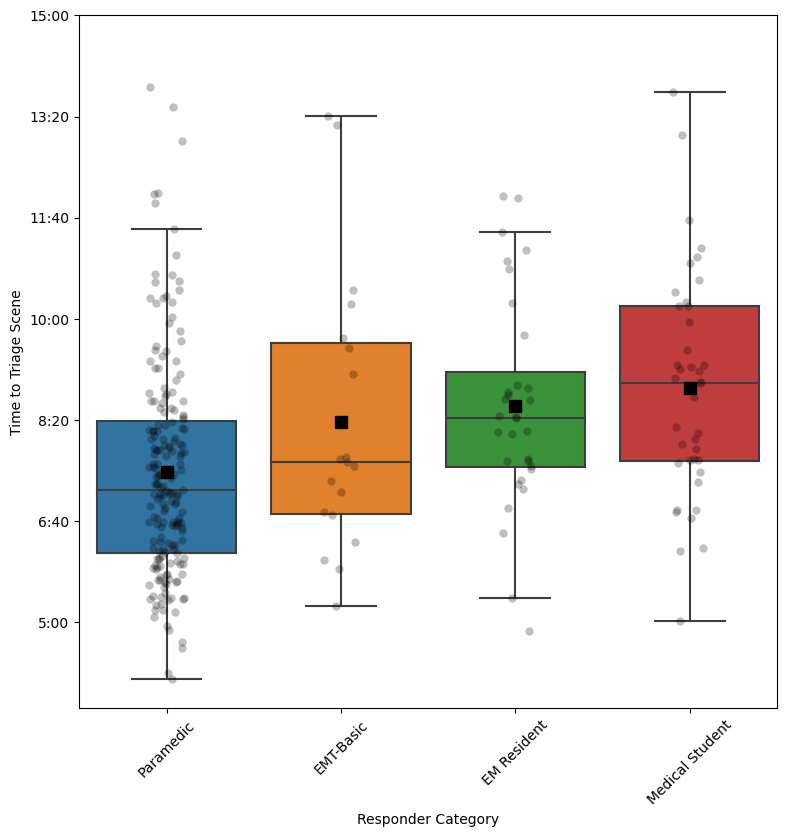

In [76]:

# Try to make it run with the new anova
if 'responder_category' not in anova_df.columns: anova_df = anova_df.rename(columns={'Group': 'responder_category'})
y_column_name = 'triage_time'
y_label = 'Time to Triage Scene'
scene_fn = lambda scene_df: scene_df.time_to_triage_scene.mean()
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=anova_df, verbose=False)

In [77]:

nu.save_data_frames(anova20240501_df=anova_df)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/anova20240501_df.csv
